# Testing - Event Tracking in Time:

If we follow the hobday definition heatwaves should only be labeled as events if they persist for 5 days or more and experience breaks of no more than two days. These criteria will need to use the boolean flags of whether a temperature exceeds the HW/CS threshold or not using a moving window to track events.

This notebook tests different ways to try and track those events and how efficiently each can be done.

### Next Steps: OCETRAC

Once heatwave events have been flagged (not just when daily temperatures exceed some threshold) we will have the beginning steps to track events spatially using the OCETRAC library. This library tracks events in time + space as clusters of pixels rather than discrete grid cells adding more context to the extreme events globally.

In [1]:
# Libraries
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os
import oisstools as ot
 
# Set Notebook Options:  -----------------------------------
box_root = ot.set_workspace("local")

# Confirm and Report what options are selected -------------
print(f"Working via directory at: {box_root}")

Working via directory at: /Users/akemberling/Library/CloudStorage/Box-Box/


In [4]:
# Load the Gulf of Maine event NetCDF ----------------------
gom_events = xr.open_dataset(f"{box_root}/RES_Data/OISST/oisst_mainstays/jacox_events/nw_atlantic_82to22.nc")
gom_events

<xarray.Dataset>
Dimensions:          (time: 14971, lat: 26, lon: 56)
Coordinates:
  * time             (time) datetime64[ns] 1982-01-01 ... 2022-12-27T12:00:00
  * lat              (lat) float32 39.12 39.38 39.62 39.88 ... 44.88 45.12 45.38
  * lon              (lon) float32 285.6 285.9 286.1 286.4 ... 298.9 299.1 299.4
    doy              (time) int64 ...
Data variables:
    sst              (time, lat, lon) float32 ...
    trend_preds      (time, lat, lon) float64 ...
    trend_residuals  (time, lat, lon) float64 ...
    detrend_var      (time, lat, lon) float64 ...
    is_hw            (time, lat, lon) bool ...
    is_cs            (time, lat, lon) bool ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

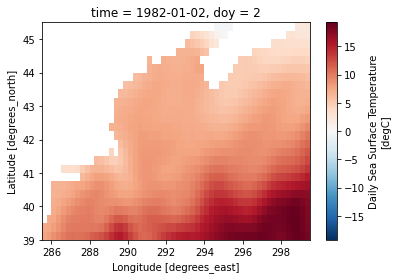

In [5]:
# Visual check
gom_events.isel(time = 1).sst.plot()

In [9]:
# 1. Consectutive days True, reset at False
gom_events["is_hw_bin"] = gom_events.is_hw.astype("int")
gom_events.is_hw_bin.diff(dim = "time")

<xarray.DataArray 'is_hw' (time: 14971, lat: 26, lon: 56)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2022-12-27T12:00:00
  * lat      (lat) float32 39.12 39.38 39.62 39.88 ... 44.62 44.88 45.12 45.38
  * lon      (lon) float32 285.6 285.9 286.1 286.4 ... 298.6 298.9 299.1 299.4
    doy      (time) int64 1 2 3 4 5 6 7 8 9 ... 354 355 356 357 358 359 360 361

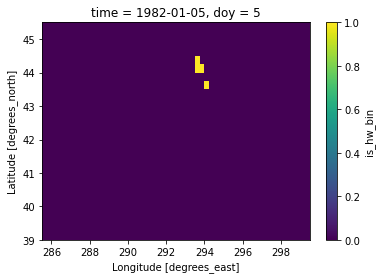

In [51]:
# Grab binary hw threshold data
df = gom_events.is_hw_bin


# Find where 5 days in a row were positive
hw_day_5 = df.rolling(time = 5, center=False, min_periods=1).sum(("lon", "lat")) == 5
hw_day_5.isel(time = 4).plot()



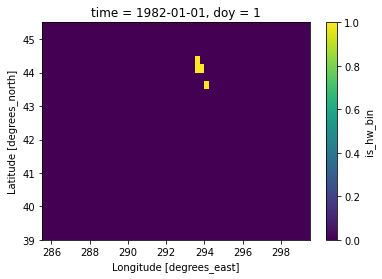

In [50]:
# Count back 5 days to flag a start
start_hw = hw_day_5.roll(time = -5)
start_hw.isel(time = 0).plot()

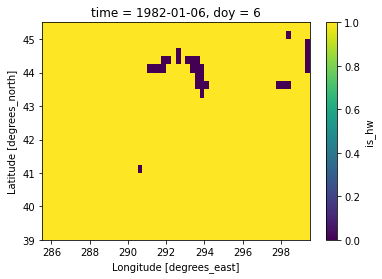

In [44]:
# Get the opposite flag in binary
inv_df = ~gom_events.is_hw
inv_df = inv_df.astype("int")

# Find where 3 days in a row it hasn't met the threshold
reset_hw = inv_df.rolling(time = 3, center=False, min_periods=1).sum(("lon", "lat")) == 3
reset_hw.isel(time = 5).plot()

# These would trigger a reset
end_hw = reset_hw.roll(time = -3)

In [ ]:
# Now flag on two conditions:
# condition 1: hw start
# condition 2

In [ ]:
# Start cumsum at the start_hw days and count until you hit a reset_hw day?

In [52]:


# 1b. Consecutive days False


In [ ]:
# 2. Consecutive Days, reset at three Falses in a row

# 3. T/F flG for above criteria

# 4. Count days as duration

In [ ]:
## Rolling Event Detection
def event_tracking(x, event_var = "is_hw"):
    print("not sure how")
    # Something